This is the very first simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using straight tracks, 8 detector layers.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants

from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors

from LLH_NN_utils import *

### Tracker toy model

Muon decaying at (x=0,z<0), producing positron with const. momentum (no timing information, so irrelevant). 8 detector layers at given z (infinite in x) that will return x position (Gaussian).

Straight path

$\tan \phi = \frac{v_x(0)}{v_z(0)}$

$z$ is fixed, so<br/>
$T = \frac{z - z_{decay}}{v_z}$

$x = v_x T = (z - z_{decay})\frac{v_x}{v_z} = (z - z_{decay}) \tan\phi$

In [2]:
N_det = 8
det_zs = np.linspace(0,(N_det-1)*0.12,N_det) #z-layers

def calc_x(z,phi):
    return z*np.tan(phi)

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#example event
z_toy = -0.17
phi_toy = 0.25

#for Gaussian
sigma = 1e-3

[0.04142136 0.09112698 0.14083261 0.19053824 0.24024387 0.28994949
 0.33965512 0.38936075]


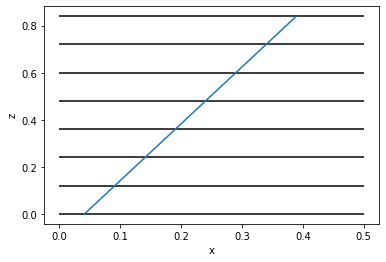

In [3]:
test = calc_x(det_zs+0.1,np.pi/8)
print(test)
plt.plot(test,det_zs)
plt.hlines(det_zs,0,0.5,color='black')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [4]:
def generate_event(z, phi):
    # generates an event from given z, phi
    # returns length 8 array of measured x-positions
    
    xs = np.empty(N_det)
    dist = det_zs-z
    x_exp = calc_x(dist,phi)
    for i in range(N_det):
        xs[i] = x_hit(x_exp[i],sigma).rvs()
    return xs

#toy MC
def MC_events(N_events, zlims=(-0.5, -0.0001), phi_lims=(0,np.pi/8)):
    
    z = np.random.uniform(*zlims, N_events)
    phi = np.random.uniform(*phi_lims, N_events)

    truth = np.vstack([z, phi]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(z[i], phi[i]))

    return events, truth

In [5]:
def plot_event(x_meas,z,phi):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title('hit locations')
    ax.set_xlabel('x')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    x_exp = calc_x(det_zs-z,phi)
    for i, z_det in enumerate(det_zs):
        #expectation
        x_dist = x_hit(x_exp[i],sigma)
        mu = x_dist.mean()
        std = x_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, x_dist.pdf(times),label=f'z={100*det_zs[i]:.0f} cm')
        
        #measured
        ax.bar(x_meas[i], 50, width=0.003, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

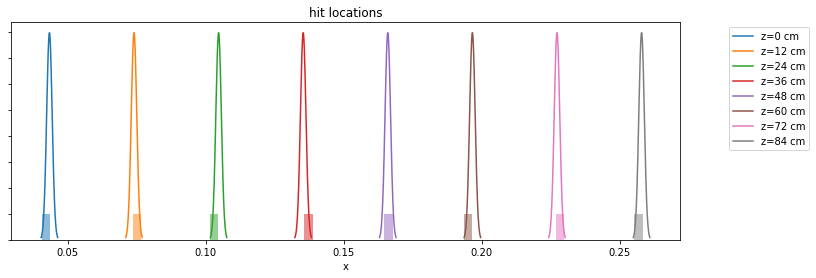

In [6]:
ev = generate_event(z_toy,phi_toy)
plot_event(ev,z_toy,phi_toy)

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [7]:
#log-likelihoods

def hit_pdf(x_meas,z,phi):
    xs = calc_x(det_zs-z,phi)
    
    llh = 0

    for i,hit in enumerate(x_meas):
        llh -= (hit-xs[i])**2/(2*sigma**2) + np.log(sigma)
    
    #store negative LLH, multiply by -1
    return -llh

In [8]:
grid_spacing = 100

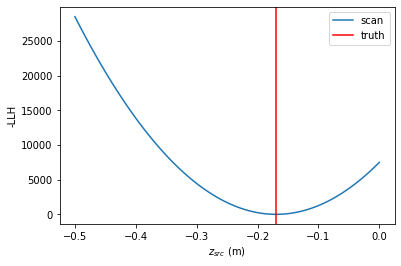

In [9]:
#full range
zs = np.linspace(-0.5,-0.0001,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, phi_toy])

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

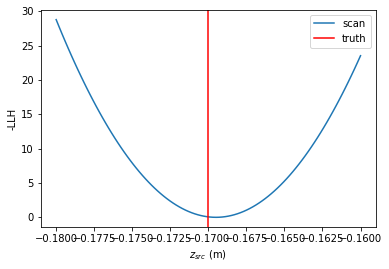

In [10]:
#zoomed in to smaller llhs
zs = np.linspace(-0.18,-0.16,grid_spacing)

llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, phi_toy])

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

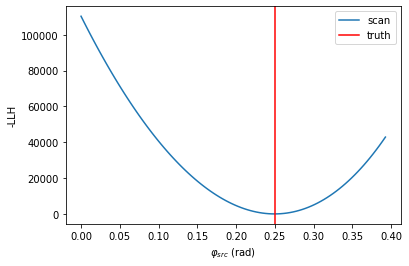

In [11]:
#full range
phis = np.linspace(0, np.pi/8, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 1, phis, [z_toy, phi_toy])

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

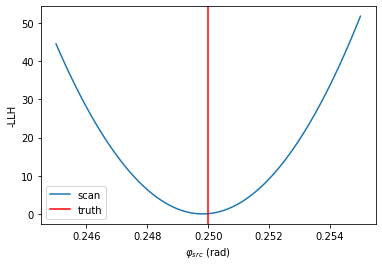

In [12]:
#zoomed in to smaller llhs
phis = np.linspace(0.245, 0.255, grid_spacing)

llh_phi_scan = map_1d(hit_pdf, ev, 1, phis, [z_toy, phi_toy])

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

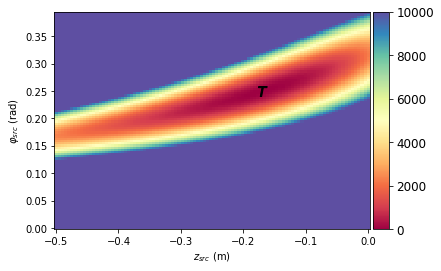

In [13]:
#full range, vmax=1e4
zs = np.linspace(-0.5,-0.0001,grid_spacing)
phis = np.linspace(0, np.pi/8, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0,1), (zs,phis), [z_toy,phi_toy])

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=10000)

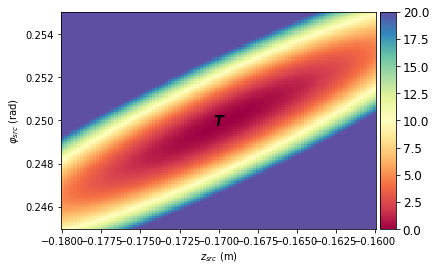

In [14]:
#zoomed in, vmax=20
zs = np.linspace(-0.18,-0.16,grid_spacing)
phis = np.linspace(0.245, 0.255, grid_spacing)

llh_z_phi_scan = map_2d(hit_pdf, ev, (0,1), (zs,phis), [z_toy,phi_toy])

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],vmax=20)

In [15]:
#make MC data to train NN
N_mc = 100000
mc, truth = MC_events(N_mc,zlims=(-0.18,-0.16),phi_lims=(0.24,0.26))

In [16]:
#neural net

hitnet = types.SimpleNamespace() 

hitnet.events = mc

hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

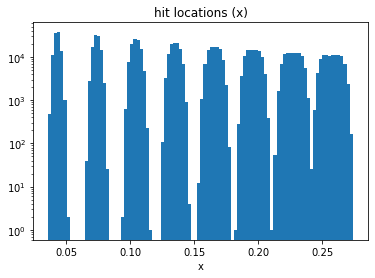

In [17]:
#histogram of hit positions (x)
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [18]:
#need trafo to combine measurements and (hypothetical) input params into input for NN
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        d = hits[:,1]-theta[:,0]
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #d,
                 theta[:,0],
                 theta[:,1],
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

#add px, pz in trafo?
    
hitnet.trafo = trafo

In [19]:
#make training and test datasets
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)


#hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=5)

In [20]:
## Neural Net

activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 4)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           160         trafo[0][0]                  

In [21]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [22]:
#training

#n_epochs = 5
#for i in range(n_epochs):
#    hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
#    hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)
#    hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=1, verbose=1, validation_data=hitnet.d_test)

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=20, verbose=1, validation_data=hitnet.d_test)

Epoch 1/40
313/313 [==============================] - 20s 63ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/40
313/313 [==============================] - 20s 65ms/step - loss: 0.6920 - val_loss: 0.6882
Epoch 3/40
313/313 [==============================] - 21s 67ms/step - loss: 0.6820 - val_loss: 0.6608
Epoch 4/40
313/313 [==============================] - 18s 59ms/step - loss: 0.6633 - val_loss: 0.6637
Epoch 5/40
313/313 [==============================] - 20s 62ms/step - loss: 0.6519 - val_loss: 0.6251
Epoch 6/40
313/313 [==============================] - 21s 67ms/step - loss: 0.6246 - val_loss: 0.6003
Epoch 7/40
313/313 [==============================] - 19s 61ms/step - loss: 0.5928 - val_loss: 0.6357
Epoch 8/40
313/313 [==============================] - 19s 60ms/step - loss: 0.5910 - val_loss: 0.6064
Epoch 9/40
313/313 [==============================] - 18s 59ms/step - loss: 0.5983 - val_loss: 0.5572
Epoch 10/40
313/313 [==============================] - 18s 59ms/step - loss: 0.562

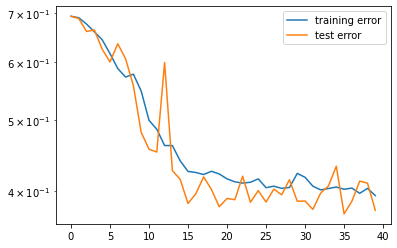

In [23]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear #result is log r(x,theta)
hitnet.llh.compile()

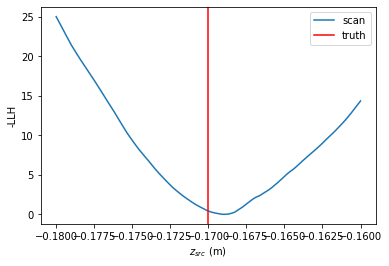

In [24]:
#neural net scan
zs = np.linspace(-0.18,-0.16,grid_spacing)

scan_t = np.vstack([zs,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

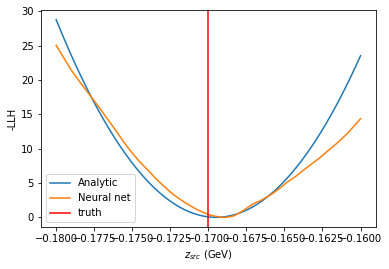

In [25]:
#comparison NN and analytical
llh_z_scan = map_1d(hit_pdf, ev, 0, zs, [z_toy, phi_toy])

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$z_{src}$ (GeV)')

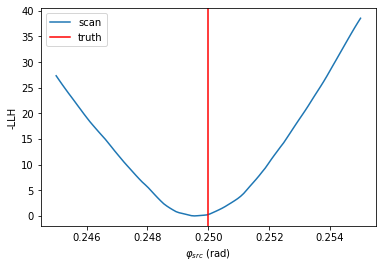

In [26]:
#neural net scan
phis = np.linspace(0.245, 0.255, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

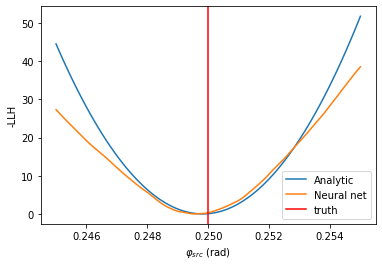

In [27]:
#comparison NN and analytical
llh_phi_scan = map_1d(hit_pdf, ev, 1, phis, [z_toy, phi_toy])

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

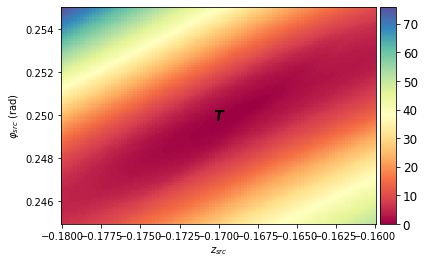

In [28]:
#neural net scan
zs = np.linspace(-0.18,-0.16,grid_spacing)
phis = np.linspace(0.245, 0.255, grid_spacing)

mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'])

NameError: name 'x_true' is not defined

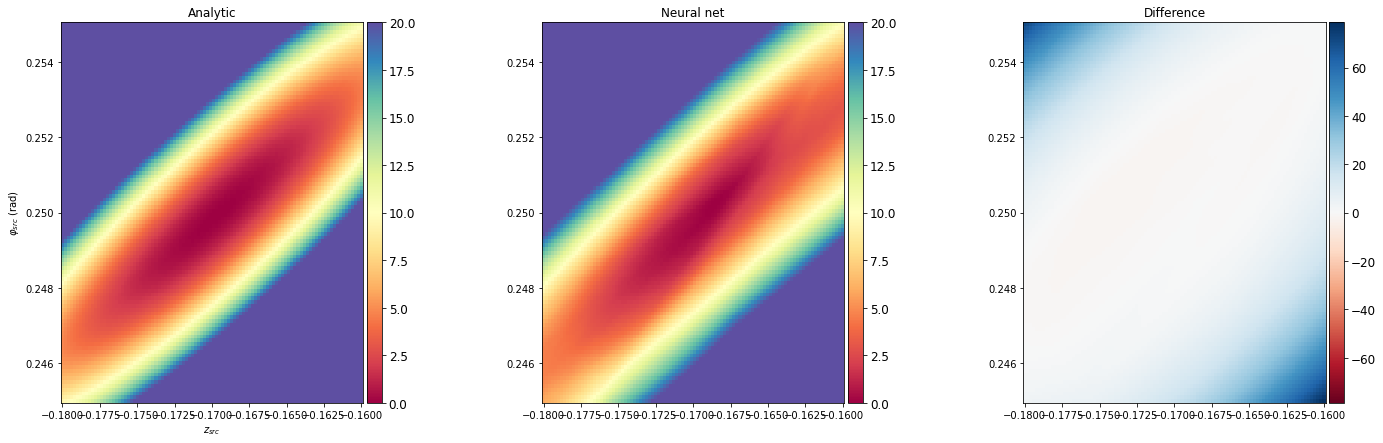

In [29]:
#comparison
llh_z_phi_scan = map_2d(hit_pdf, ev, (0,1), (zs,phis), [z_toy,phi_toy])

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'],vmax=20)

Training on small param table (small llhs) gives good results, comparable with Ice cube